In [180]:
#This model was built using the 20 most common codes from AdmittingDiagnosis and ICD9 Diagnosis codes 1 - 4
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy

#location in s3
#bckt = 'inpatientclaims'
#data_key = 'DGNS_1_4.csv'
#data_location = 's3://{}/{}'.format(bckt,data_key)

#set headers and read into df
headers = ["PaymentAmount", "AdmittingDiagnosis", "Deductible", "DayCount", "ICD9_DGNS_CD_1", "ICD9_DGNS_CD_2", "ICD9_DGNS_CD_3",
          "ICD9_DGNS_CD_4"]

#read data
#na values = 0
df = pd.read_csv('TwentyMostCommonData.csv', header = None, names = headers, na_values = "0", low_memory = False)

#drop headers from table
df.drop([0], inplace = True)

#replace NaN with 0
df = df.replace(np.nan, '0')

In [181]:
#convert 'PaymentAmount' to numeric values
df["PaymentAmount"] = pd.to_numeric(df["PaymentAmount"])

#drop PaymentAmount == 0 or > 25000
#attempt to handle outliers
df = df[df['PaymentAmount'] != 0]
df.drop(df[df['PaymentAmount'] > 25000].index, inplace = True)

#improves accuracy
df = df.drop(columns = 'DayCount')
#df = df.drop(columns = 'Deductible')

In [182]:
#create dummy variables
dummyAdmittingDiagnosis = pd.get_dummies(df['AdmittingDiagnosis'], prefix = 'AD')
dummyDgnsCd1 = pd.get_dummies(df['ICD9_DGNS_CD_1'], prefix = 'CD1')
dummyDgnsCd2 = pd.get_dummies(df['ICD9_DGNS_CD_2'], prefix = 'CD2')
dummyDgnsCd3 = pd.get_dummies(df['ICD9_DGNS_CD_3'], prefix = 'CD3')
dummyDgnsCd4 = pd.get_dummies(df['ICD9_DGNS_CD_4'], prefix = 'CD4')

In [183]:
#drop columns
del df['AdmittingDiagnosis']
del df['ICD9_DGNS_CD_1']
del df['ICD9_DGNS_CD_2']
del df['ICD9_DGNS_CD_3']
del df['ICD9_DGNS_CD_4']

In [184]:
#concatenate dummies onto table
df = pd.concat([df, dummyAdmittingDiagnosis], axis = 1)
df = pd.concat([df, dummyDgnsCd1], axis = 1)
df = pd.concat([df, dummyDgnsCd2], axis = 1)
df = pd.concat([df, dummyDgnsCd3], axis = 1)
df = pd.concat([df, dummyDgnsCd4], axis = 1)

In [185]:
#handling of outliers
q_low = df["PaymentAmount"].quantile(0.01)
q_hi  = df["PaymentAmount"].quantile(0.99)
df = df[(df["PaymentAmount"] < q_hi) & (df["PaymentAmount"] > q_low)]

In [186]:
#drop df without PymentAmount into x
x = df.drop('PaymentAmount', axis = 1)

In [187]:
#set PaymentAmount as target in y
y = df[['PaymentAmount']]

In [188]:
#split dataset into train and test set
#20% for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=1)

In [189]:
#assign linear regression and fit
reg = LinearRegression()
reg.fit(x_train, y_train)
y_predicted = reg.predict(x_test)

In [190]:
#cast to list
predicted = y_predicted.tolist()
test = y_test.values.tolist()
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predicted))
print('R²: %.2f' % r2_score(y_test, y_predicted))

Mean squared error: 8323341.72
R²: 0.46


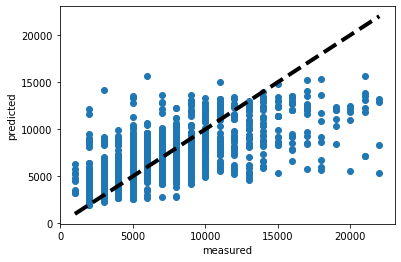

In [191]:
#plot test values
fig, ax = plt.subplots()
ax.scatter(test, predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

In [192]:
#testing predictions
reg.predict(x[0:10])


array([[5938.91210938],
       [7222.54101562],
       [9032.38476562],
       [5868.10742188],
       [2892.45507812],
       [5861.37109375],
       [4518.3671875 ],
       [5259.07421875],
       [6309.83789062],
       [4764.04492188]])